In [1]:
from joblib import load
import sys
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('omicDC_results_Prostate/')]
groups = ['Histone','TFs']
feature_names = [i for i in features if (i.split('_')[0] in groups)]
DNA_features = {feture: load(f'omicDC_results_Prostate/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/193 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict


result_dict = defaultdict(set)

with open("prostate.bed", "r") as bed_file:

    for line in bed_file:
        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [6]:
win_in = []
win_out = []
width = 50000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

  0%|          | 0/25 [00:00<?, ?it/s]

In [7]:
win_in[:10]

[['chr1', 21900889, 21950889],
 ['chr1', 223293021, 223343021],
 ['chr1', 241659488, 241709488],
 ['chr1', 241663584, 241713584],
 ['chr1', 243461732, 243511732],
 ['chr1', 176184933, 176234933],
 ['chr1', 215780970, 215830970],
 ['chr1', 241045098, 241095098],
 ['chr1', 191516270, 191566270],
 ['chr1', 224034415, 224084415]]

In [8]:
win_out[:10]

[['chr1', 20900889, 20950889],
 ['chr1', 20400889, 20450889],
 ['chr1', 20150889, 20200889],
 ['chr1', 20400889, 20450889],
 ['chr1', 20900889, 20950889],
 ['chr1', 21900889, 21950889],
 ['chr1', 222293021, 222343021],
 ['chr1', 221793021, 221843021],
 ['chr1', 221543021, 221593021],
 ['chr1', 221793021, 221843021]]

In [9]:
print(len(win_in), len(win_out))

26933 139050


In [10]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in) * 2, replace=False)]

In [11]:
print(len(ints_in1), len(ints_out1))

26933 53866


In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

array([['chr12', '98627760', '98677760', '0'],
       ['chr8', '84651889', '84701889', '1'],
       ['chr15', '47423988', '47473988', '1'],
       ['chr5', '147560462', '147610462', '0'],
       ['chr3', '131847213', '131897213', '1'],
       ['chr3', '125890479', '125940479', '0'],
       ['chr3', '3413270', '3463270', '0'],
       ['chr2', '178746951', '178796951', '0'],
       ['chr2', '13197561', '13247561', '0'],
       ['chr10', '12984541', '13034541', '0']], dtype='<U21')

In [13]:
import numpy as np
import torch
from tqdm import tqdm 
from sklearn.preprocessing import StandardScaler

X = []
y = []

pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in feature_names:
        source = DNA_features[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32)
        X.append(new_row)
        y.append(target)
    else:
        continue 

pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 80799/80799 [31:27<00:00, 42.82it/s]


In [14]:
X = np.array(X)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [15]:
X = np.array(X)
X

array([[ 1.1466234 , -0.10536692, -0.08160447, ..., -0.06073679,
         0.09930918, -0.1875134 ],
       [-0.34373358, -0.10536692, -0.08160447, ..., -0.06073679,
        -0.26492596, -0.1875134 ],
       [-0.34373358, -0.10536692, -0.08160447, ..., -0.06073679,
        -0.26492596, -0.1875134 ],
       ...,
       [ 0.62458736, -0.10536692, -0.08160447, ..., -0.06073679,
        -0.26492596, -0.1875134 ],
       [-0.34373358, -0.10536692, -0.08160447, ..., -0.06073679,
        -0.26492596, -0.1875134 ],
       [ 0.18252565, -0.10536692, -0.08160447, ..., -0.06073679,
         0.16568267, -0.1875134 ]], dtype=float32)

In [16]:
X.shape

(80799, 193)

In [17]:
y

tensor([0, 1, 1,  ..., 1, 1, 1])

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))


2023-05-16 01:36:02.545473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 01:36:03.147111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10
2020/2020 [==============================] - 22s 11ms/step - loss: 0.6367 - accuracy: 0.6673 - val_loss: 0.6375 - val_accuracy: 0.6640
Epoch 2/10
2020/2020 [==============================] - 21s 10ms/step - loss: 0.6360 - accuracy: 0.6673 - val_loss: 0.6376 - val_accuracy: 0.6640
Epoch 3/10
2020/2020 [==============================] - 21s 11ms/step - loss: 0.6358 - accuracy: 0.6673 - val_loss: 0.6373 - val_accuracy: 0.6640
Epoch 4/10
2020/2020 [==============================] - 22s 11ms/step - loss: 0.6356 - accuracy: 0.6673 - val_loss: 0.6381 - val_accuracy: 0.6640
Epoch 5/10
2020/2020 [==============================] - 21s 11ms/step - loss: 0.6355 - accuracy: 0.6673 - val_loss: 0.6373 - val_accuracy: 0.6640
Epoch 6/10
2020/2020 [==============================] - 21s 11ms/step - loss: 0.6353 - accuracy: 0.6673 - val_loss: 0.6373 - val_accuracy: 0.6640
Epoch 7/10
2020/2020 [==============================] - 21s 11ms/step - loss: 0.6352 - accuracy: 0.6673 - val_loss: 0.6374 -

In [19]:
from copy import deepcopy
X_copy = deepcopy(X)
y_copy = deepcopy(y)

In [20]:
X = X_copy
y = y_copy

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_23408/3757297636.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_23408/3757297636.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6345, Train F1-score: 0.4500, Train ROC-AUC: 0.4074, Train PR-AUC: 0.3714, Test Loss: 0.6349, Test F1-score: 0.5353, Test ROC-AUC: 0.5400, Test PR-AUC: 0.3850
Epoch [2/20], Train Loss: 0.6308, Train F1-score: 0.8048, Train ROC-AUC: 0.7308, Train PR-AUC: 0.2232, Test Loss: 0.6331, Test F1-score: 0.5445, Test ROC-AUC: 0.5436, Test PR-AUC: 0.3924
Epoch [3/20], Train Loss: 0.6255, Train F1-score: 0.6205, Train ROC-AUC: 0.4091, Train PR-AUC: 0.2302, Test Loss: 0.6323, Test F1-score: 0.5542, Test ROC-AUC: 0.5511, Test PR-AUC: 0.3965
Epoch [4/20], Train Loss: 0.6173, Train F1-score: 0.7111, Train ROC-AUC: 0.6667, Train PR-AUC: 0.2472, Test Loss: 0.6332, Test F1-score: 0.5629, Test ROC-AUC: 0.5556, Test PR-AUC: 0.3968
Epoch [5/20], Train Loss: 0.6071, Train F1-score: 1.0000, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6395, Test F1-score: 0.5785, Test ROC-AUC: 0.5554, Test PR-AUC: 0.3947
Epoch [6/20], Train Loss: 0.5946, Train F1-score: 0.7333, Train R

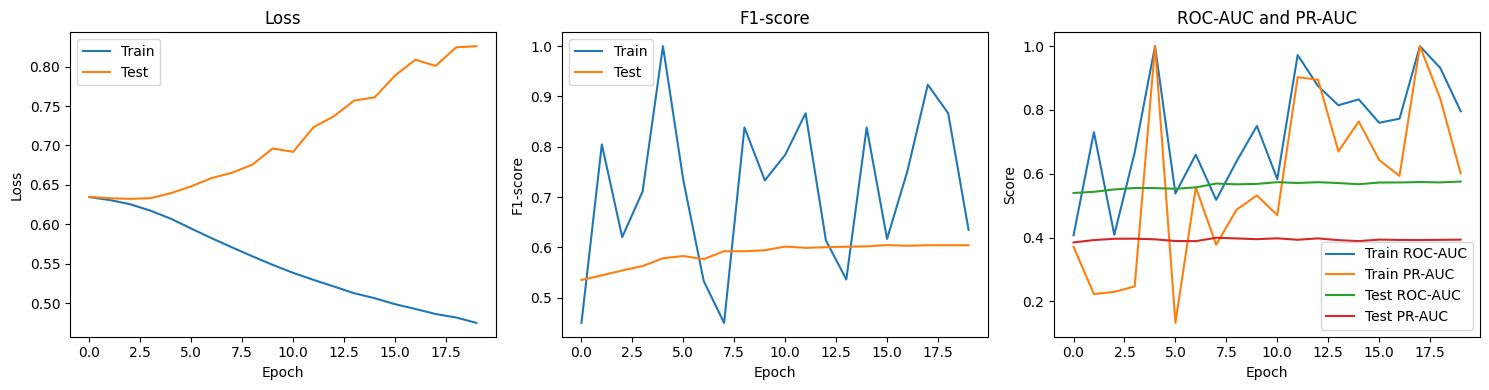

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1
num_epochs = 20
batch_size = 64
learning_rate = 0.0001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_23408/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_23408/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6443, Train F1-score: 0.5591, Train ROC-AUC: 0.5170, Train PR-AUC: 0.3537, Test Loss: 0.6362, Test F1-score: 0.5391, Test ROC-AUC: 0.5276, Test PR-AUC: 0.3689
Epoch [2/20], Train Loss: 0.6343, Train F1-score: 0.5423, Train ROC-AUC: 0.5285, Train PR-AUC: 0.3653, Test Loss: 0.6355, Test F1-score: 0.5393, Test ROC-AUC: 0.5341, Test PR-AUC: 0.3770
Epoch [3/20], Train Loss: 0.6340, Train F1-score: 0.5427, Train ROC-AUC: 0.5268, Train PR-AUC: 0.3672, Test Loss: 0.6346, Test F1-score: 0.5396, Test ROC-AUC: 0.5374, Test PR-AUC: 0.3823
Epoch [4/20], Train Loss: 0.6330, Train F1-score: 0.5436, Train ROC-AUC: 0.5343, Train PR-AUC: 0.3745, Test Loss: 0.6345, Test F1-score: 0.5412, Test ROC-AUC: 0.5392, Test PR-AUC: 0.3839
Epoch [5/20], Train Loss: 0.6326, Train F1-score: 0.5441, Train ROC-AUC: 0.5364, Train PR-AUC: 0.3766, Test Loss: 0.6342, Test F1-score: 0.5425, Test ROC-AUC: 0.5364, Test PR-AUC: 0.3831
Epoch [6/20], Train Loss: 0.6326, Train F1-score: 0.5453, Train R

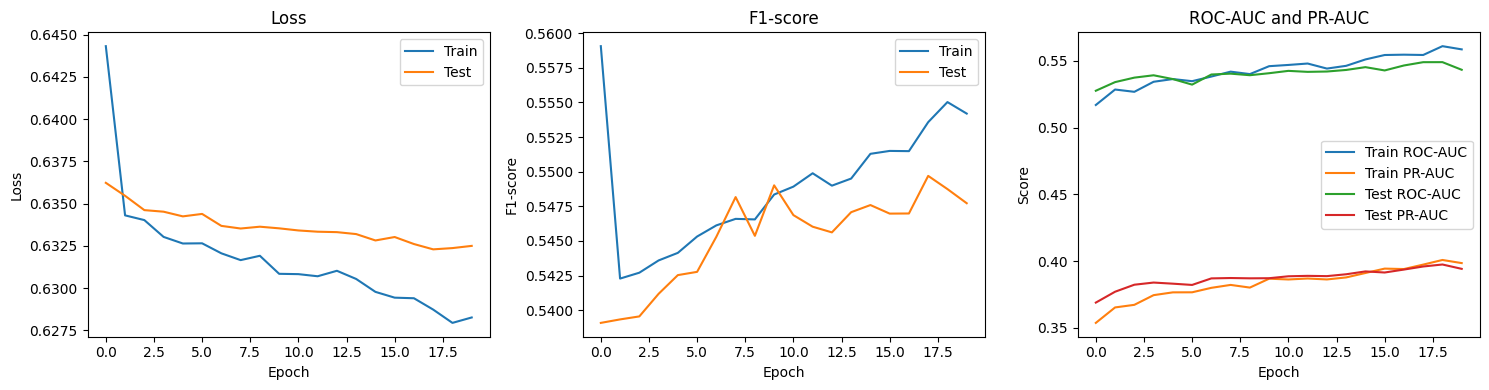

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import accuracy_score
def permutation_importance(model, X_test, y_test, metric, feature_names):
    base_score = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test)) > 0.5).cpu().numpy().astype(int))
    feature_importances = []
    X_test_permuted = X_test.clone()
    for i in range(X_test.shape[-1]):
        np.random.shuffle(X_test_permuted[:, :, i].cpu().numpy())
        score_permuted = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test_permuted)) > 0.5).cpu().numpy().astype(int))
        feature_importances.append(base_score - score_permuted)
        X_test_permuted = X_test.clone() 
    
    feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_importances

feat_names = feature_names

sorted_feature_importances = permutation_importance(model, X_test, y_test, accuracy_score, feat_names)

for name, imp in sorted_feature_importances:
    print(f'Feature {name} importance: {imp}')


Feature TFs_MYBL2 importance: 0.001299504950495023
Feature TFs_EWSR1 importance: 0.0008663366336633116
Feature Histone_H4K20me1 importance: 0.0007425742574257432
Feature Histone_H2AK119Ub importance: 0.0005569306930692797
Feature TFs_ASH2L importance: 0.0004950495049504955
Feature TFs_ELF1 importance: 0.0004950495049504955
Feature Histone_H3.3 importance: 0.0004331683168317113
Feature TFs_GABPA importance: 0.0004331683168317113
Feature TFs_RAD21 importance: 0.0004331683168317113
Feature TFs_SUZ12 importance: 0.0004331683168317113
Feature TFs_RTF1 importance: 0.0003712871287128161
Feature Histone_H3K4me3 importance: 0.00024752475247524774
Feature TFs_COBLL1 importance: 0.00024752475247524774
Feature TFs_ETV4 importance: 0.00024752475247524774
Feature TFs_MEN1 importance: 0.00024752475247524774
Feature TFs_TRIM24 importance: 0.00024752475247524774
Feature Histone_H3K14ac importance: 0.00018564356435646356
Feature Histone_H4K5ac importance: 0.00018564356435646356
Feature TFs_Epitope tags 

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_23408/528756788.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_23408/528756788.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6371, Train F1-score: 0.6667, Train ROC-AUC: 0.4000, Train PR-AUC: 0.4199, Test Loss: 0.6364, Test F1-score: 0.5396, Test ROC-AUC: 0.5152, Test PR-AUC: 0.3642
Epoch [2/20], Train Loss: 0.6348, Train F1-score: 0.5333, Train ROC-AUC: 0.6600, Train PR-AUC: 0.5575, Test Loss: 0.6349, Test F1-score: 0.5406, Test ROC-AUC: 0.5378, Test PR-AUC: 0.3829
Epoch [3/20], Train Loss: 0.6336, Train F1-score: 0.6205, Train ROC-AUC: 0.4545, Train PR-AUC: 0.2315, Test Loss: 0.6344, Test F1-score: 0.5446, Test ROC-AUC: 0.5399, Test PR-AUC: 0.3829
Epoch [4/20], Train Loss: 0.6327, Train F1-score: 0.6205, Train ROC-AUC: 0.5227, Train PR-AUC: 0.2461, Test Loss: 0.6349, Test F1-score: 0.5435, Test ROC-AUC: 0.5368, Test PR-AUC: 0.3826
Epoch [5/20], Train Loss: 0.6321, Train F1-score: 0.5333, Train ROC-AUC: 0.6000, Train PR-AUC: 0.5262, Test Loss: 0.6333, Test F1-score: 0.5440, Test ROC-AUC: 0.5476, Test PR-AUC: 0.3892
Epoch [6/20], Train Loss: 0.6319, Train F1-score: 0.6205, Train R

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs[:, 1] > 0.5).long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        predicted_probs.extend(probs[:, 1].detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_probs = softmax(test_outputs)
        test_preds = (test_probs[:, 1] > 0.5).long()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        softmax = nn.Softmax(dim=1)
        test_probs = softmax(test_outputs)
        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_23408/1862407589.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_23408/1862407589.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6346, Train F1-score: 0.5450, Train ROC-AUC: 0.5246, Train PR-AUC: 0.3639, Test Loss: 0.6338, Test F1-score: 0.5479, Test ROC-AUC: 0.5368, Test PR-AUC: 0.3863
Epoch [2/20], Train Loss: 0.6308, Train F1-score: 0.5569, Train ROC-AUC: 0.5445, Train PR-AUC: 0.3881, Test Loss: 0.6345, Test F1-score: 0.5496, Test ROC-AUC: 0.5352, Test PR-AUC: 0.3841
Epoch [3/20], Train Loss: 0.6269, Train F1-score: 0.5714, Train ROC-AUC: 0.5643, Train PR-AUC: 0.4099, Test Loss: 0.6336, Test F1-score: 0.5604, Test ROC-AUC: 0.5443, Test PR-AUC: 0.3928
Epoch [4/20], Train Loss: 0.6213, Train F1-score: 0.5892, Train ROC-AUC: 0.5869, Train PR-AUC: 0.4355, Test Loss: 0.6350, Test F1-score: 0.5721, Test ROC-AUC: 0.5453, Test PR-AUC: 0.3939
Epoch [5/20], Train Loss: 0.6150, Train F1-score: 0.6075, Train ROC-AUC: 0.6096, Train PR-AUC: 0.4607, Test Loss: 0.6355, Test F1-score: 0.5763, Test ROC-AUC: 0.5482, Test PR-AUC: 0.3962
Epoch [6/20], Train Loss: 0.6091, Train F1-score: 0.6216, Train R

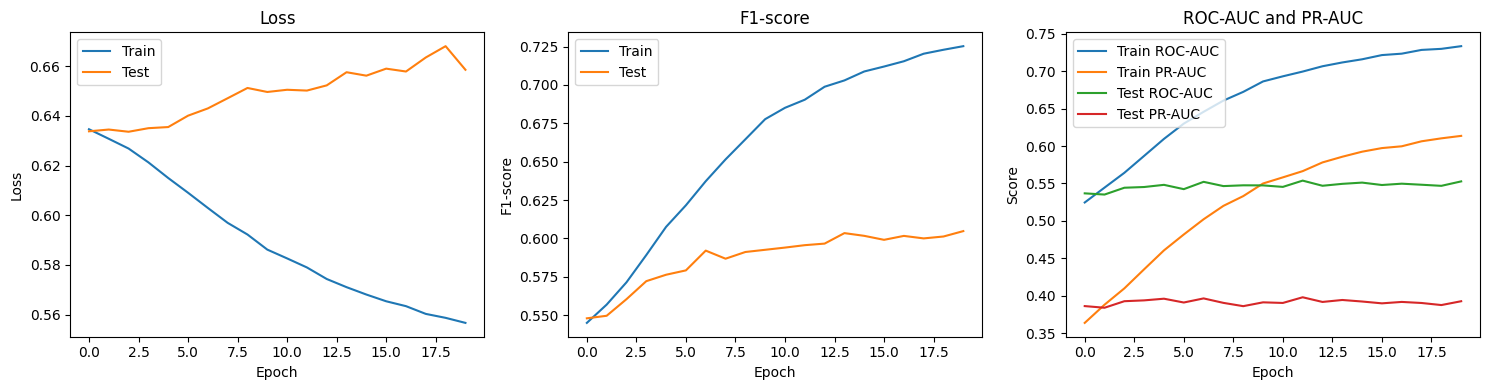

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_epochs = 30
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

dropout_prob = 0.5
train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(outputs.detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_preds = (test_outputs > 0.5).float()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_23408/792856689.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)
/tmp/ipykernel_23408/792856689.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)


Epoch [1/30], Train Loss: 0.6365, Train F1-score: 0.5458, Train ROC-AUC: 0.5244, Train PR-AUC: 0.3609, Test Loss: 0.6356, Test F1-score: 0.5415, Test ROC-AUC: 0.5324, Test PR-AUC: 0.3784
Epoch [2/30], Train Loss: 0.6332, Train F1-score: 0.5466, Train ROC-AUC: 0.5353, Train PR-AUC: 0.3760, Test Loss: 0.6339, Test F1-score: 0.5456, Test ROC-AUC: 0.5378, Test PR-AUC: 0.3863
Epoch [3/30], Train Loss: 0.6312, Train F1-score: 0.5527, Train ROC-AUC: 0.5467, Train PR-AUC: 0.3875, Test Loss: 0.6342, Test F1-score: 0.5480, Test ROC-AUC: 0.5395, Test PR-AUC: 0.3869
Epoch [4/30], Train Loss: 0.6289, Train F1-score: 0.5581, Train ROC-AUC: 0.5565, Train PR-AUC: 0.3980, Test Loss: 0.6330, Test F1-score: 0.5516, Test ROC-AUC: 0.5465, Test PR-AUC: 0.3920
Epoch [5/30], Train Loss: 0.6263, Train F1-score: 0.5658, Train ROC-AUC: 0.5685, Train PR-AUC: 0.4094, Test Loss: 0.6329, Test F1-score: 0.5524, Test ROC-AUC: 0.5463, Test PR-AUC: 0.3918
Epoch [6/30], Train Loss: 0.6230, Train F1-score: 0.5725, Train R

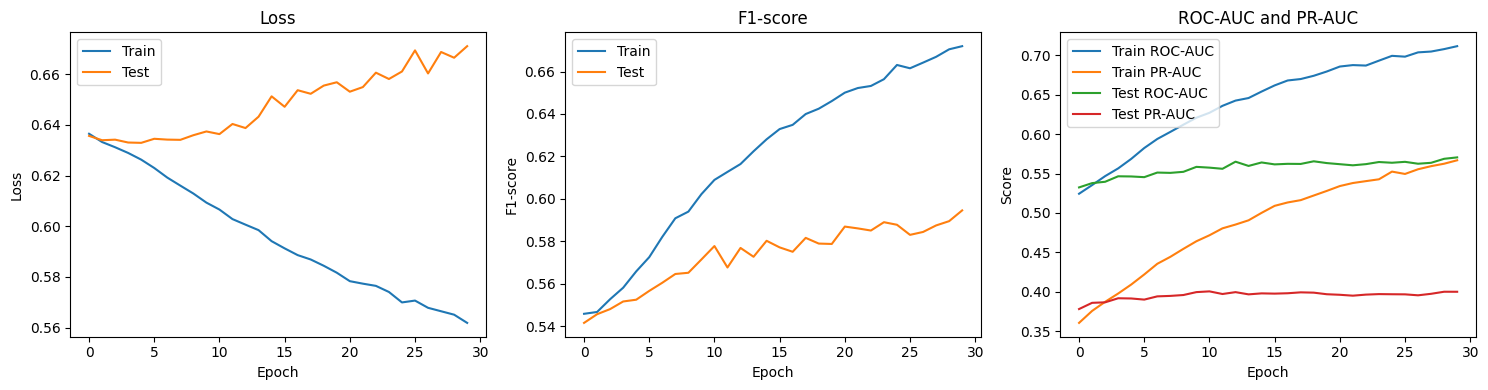

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = nn.functional.softmax(test_outputs, dim=1)
        test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
        _, test_preds = torch.max(test_outputs, 1)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)

/tmp/ipykernel_23408/140274637.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_23408/140274637.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)
100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:57<00:00, 70.24it/s]


Epoch [1/20], Train Loss: 0.6361, Train F1-score: 0.5419, Train ROC-AUC: 0.5212, Train PR-AUC: 0.3588, Test Loss: 0.6373, Test F1-score: 0.5390, Test ROC-AUC: 0.5364, Test PR-AUC: 0.3812


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:59<00:00, 67.77it/s]


Epoch [2/20], Train Loss: 0.6330, Train F1-score: 0.5452, Train ROC-AUC: 0.5336, Train PR-AUC: 0.3726, Test Loss: 0.6344, Test F1-score: 0.5416, Test ROC-AUC: 0.5400, Test PR-AUC: 0.3813


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:59<00:00, 67.84it/s]


Epoch [3/20], Train Loss: 0.6316, Train F1-score: 0.5514, Train ROC-AUC: 0.5414, Train PR-AUC: 0.3811, Test Loss: 0.6341, Test F1-score: 0.5466, Test ROC-AUC: 0.5373, Test PR-AUC: 0.3806


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [01:00<00:00, 66.45it/s]


Epoch [4/20], Train Loss: 0.6292, Train F1-score: 0.5569, Train ROC-AUC: 0.5508, Train PR-AUC: 0.3931, Test Loss: 0.6343, Test F1-score: 0.5517, Test ROC-AUC: 0.5433, Test PR-AUC: 0.3888


100%|████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:58<00:00, 68.73it/s]


Epoch [5/20], Train Loss: 0.6264, Train F1-score: 0.5638, Train ROC-AUC: 0.5624, Train PR-AUC: 0.4065, Test Loss: 0.6327, Test F1-score: 0.5519, Test ROC-AUC: 0.5497, Test PR-AUC: 0.3944


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:56<00:00, 71.91it/s]


Epoch [6/20], Train Loss: 0.6234, Train F1-score: 0.5735, Train ROC-AUC: 0.5733, Train PR-AUC: 0.4184, Test Loss: 0.6341, Test F1-score: 0.5452, Test ROC-AUC: 0.5427, Test PR-AUC: 0.3903


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:56<00:00, 71.63it/s]


Epoch [7/20], Train Loss: 0.6199, Train F1-score: 0.5813, Train ROC-AUC: 0.5845, Train PR-AUC: 0.4311, Test Loss: 0.6340, Test F1-score: 0.5619, Test ROC-AUC: 0.5487, Test PR-AUC: 0.3924


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:56<00:00, 71.89it/s]


Epoch [8/20], Train Loss: 0.6159, Train F1-score: 0.5920, Train ROC-AUC: 0.5967, Train PR-AUC: 0.4445, Test Loss: 0.6337, Test F1-score: 0.5595, Test ROC-AUC: 0.5486, Test PR-AUC: 0.3909


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:56<00:00, 71.61it/s]


Epoch [9/20], Train Loss: 0.6125, Train F1-score: 0.5980, Train ROC-AUC: 0.6071, Train PR-AUC: 0.4546, Test Loss: 0.6387, Test F1-score: 0.5663, Test ROC-AUC: 0.5518, Test PR-AUC: 0.3979


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:56<00:00, 71.92it/s]


Epoch [10/20], Train Loss: 0.6085, Train F1-score: 0.6070, Train ROC-AUC: 0.6136, Train PR-AUC: 0.4634, Test Loss: 0.6383, Test F1-score: 0.5645, Test ROC-AUC: 0.5539, Test PR-AUC: 0.3929


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:55<00:00, 72.88it/s]


Epoch [11/20], Train Loss: 0.6048, Train F1-score: 0.6135, Train ROC-AUC: 0.6245, Train PR-AUC: 0.4746, Test Loss: 0.6400, Test F1-score: 0.5754, Test ROC-AUC: 0.5635, Test PR-AUC: 0.4035


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:55<00:00, 73.15it/s]


Epoch [12/20], Train Loss: 0.6012, Train F1-score: 0.6201, Train ROC-AUC: 0.6307, Train PR-AUC: 0.4823, Test Loss: 0.6473, Test F1-score: 0.5785, Test ROC-AUC: 0.5594, Test PR-AUC: 0.3998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:54<00:00, 73.52it/s]


Epoch [13/20], Train Loss: 0.5987, Train F1-score: 0.6217, Train ROC-AUC: 0.6375, Train PR-AUC: 0.4874, Test Loss: 0.6480, Test F1-score: 0.5769, Test ROC-AUC: 0.5558, Test PR-AUC: 0.3939


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:55<00:00, 73.30it/s]


Epoch [14/20], Train Loss: 0.5937, Train F1-score: 0.6281, Train ROC-AUC: 0.6474, Train PR-AUC: 0.5003, Test Loss: 0.6487, Test F1-score: 0.5739, Test ROC-AUC: 0.5561, Test PR-AUC: 0.3938


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:54<00:00, 73.64it/s]


Epoch [15/20], Train Loss: 0.5900, Train F1-score: 0.6359, Train ROC-AUC: 0.6562, Train PR-AUC: 0.5099, Test Loss: 0.6517, Test F1-score: 0.5828, Test ROC-AUC: 0.5624, Test PR-AUC: 0.4016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:55<00:00, 73.43it/s]


Epoch [16/20], Train Loss: 0.5864, Train F1-score: 0.6406, Train ROC-AUC: 0.6656, Train PR-AUC: 0.5166, Test Loss: 0.6585, Test F1-score: 0.5829, Test ROC-AUC: 0.5591, Test PR-AUC: 0.3987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:54<00:00, 73.57it/s]


Epoch [17/20], Train Loss: 0.5845, Train F1-score: 0.6412, Train ROC-AUC: 0.6666, Train PR-AUC: 0.5214, Test Loss: 0.6578, Test F1-score: 0.5805, Test ROC-AUC: 0.5641, Test PR-AUC: 0.3993


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:54<00:00, 73.55it/s]


Epoch [18/20], Train Loss: 0.5790, Train F1-score: 0.6495, Train ROC-AUC: 0.6764, Train PR-AUC: 0.5322, Test Loss: 0.6640, Test F1-score: 0.5840, Test ROC-AUC: 0.5644, Test PR-AUC: 0.4017


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:54<00:00, 73.89it/s]


Epoch [19/20], Train Loss: 0.5770, Train F1-score: 0.6511, Train ROC-AUC: 0.6794, Train PR-AUC: 0.5347, Test Loss: 0.6803, Test F1-score: 0.5886, Test ROC-AUC: 0.5638, Test PR-AUC: 0.3994


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:54<00:00, 73.96it/s]


Epoch [20/20], Train Loss: 0.5756, Train F1-score: 0.6555, Train ROC-AUC: 0.6847, Train PR-AUC: 0.5397, Test Loss: 0.6600, Test F1-score: 0.5873, Test ROC-AUC: 0.5643, Test PR-AUC: 0.3989


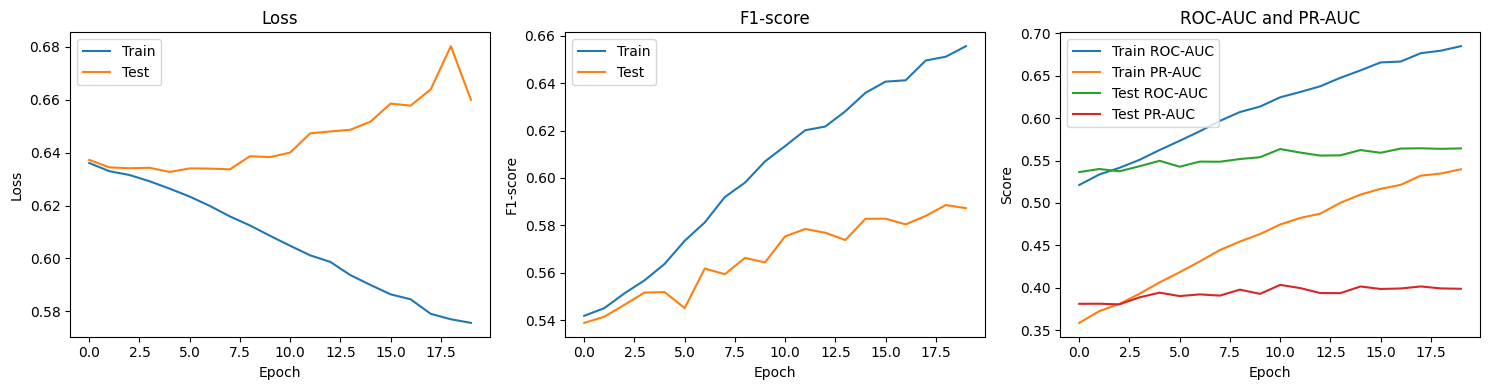

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = X.shape[1]
hidden_size = 128
output_size = 2

model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

epochs = 50
train_loss_history = []
train_f1_history = []
train_roc_auc_history = []
train_pr_auc_history = []
test_loss_history = []
test_f1_history = []
test_roc_auc_history = []
test_pr_auc_history = []


for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_f1 = f1_score(y_train, train_predicted, average='weighted')
        train_loss_history.append(loss.item())
        train_f1_history.append(train_f1)
        train_roc_auc_history.append(roc_auc_score(y_train, train_outputs[:, 1]))
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_outputs[:, 1])
        train_pr_auc_history.append(auc(train_recall, train_precision))
    
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_loss = criterion(test_outputs, y_test)
        test_f1 = f1_score(y_test, test_predicted, average='weighted')
        test_loss_history.append(test_loss.item())
        test_f1_history.append(test_f1)
        test_roc_auc = roc_auc_score(y_test, test_outputs[:, 1])
        test_roc_auc_history.append(test_roc_auc)
        test_precision, test_recall, _ = precision_recall_curve(y_test, test_outputs[:, 1])
        test_pr_auc = auc(test_recall, test_precision)
        test_pr_auc_history.append(test_pr_auc)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train F1-score: {train_f1:.4f}, Train ROC-AUC: {train_roc_auc_history[-1]:.4f}, Train PR-AUC: {train_pr_auc_history[-1]:.4f}, Test Loss: {test_loss.item():.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc_history[-1]:.4f}, Test PR-AUC: {test_pr_auc_history[-1]:.4f}')

Epoch [1/50], Train Loss: 0.7036, Train F1-score: 0.5749, Train ROC-AUC: 0.5210, Train PR-AUC: 0.3574, Test Loss: 0.6847, Test F1-score: 0.5754, Test ROC-AUC: 0.5229, Test PR-AUC: 0.3677
Epoch [2/50], Train Loss: 0.6854, Train F1-score: 0.5775, Train ROC-AUC: 0.5217, Train PR-AUC: 0.3591, Test Loss: 0.6695, Test F1-score: 0.5774, Test ROC-AUC: 0.5249, Test PR-AUC: 0.3689
Epoch [3/50], Train Loss: 0.6698, Train F1-score: 0.5676, Train ROC-AUC: 0.5219, Train PR-AUC: 0.3596, Test Loss: 0.6588, Test F1-score: 0.5650, Test ROC-AUC: 0.5248, Test PR-AUC: 0.3684
Epoch [4/50], Train Loss: 0.6586, Train F1-score: 0.5537, Train ROC-AUC: 0.5220, Train PR-AUC: 0.3599, Test Loss: 0.6509, Test F1-score: 0.5499, Test ROC-AUC: 0.5242, Test PR-AUC: 0.3676
Epoch [5/50], Train Loss: 0.6501, Train F1-score: 0.5475, Train ROC-AUC: 0.5222, Train PR-AUC: 0.3602, Test Loss: 0.6460, Test F1-score: 0.5434, Test ROC-AUC: 0.5239, Test PR-AUC: 0.3676
Epoch [6/50], Train Loss: 0.6444, Train F1-score: 0.5457, Train R

Epoch [45/50], Train Loss: 0.6287, Train F1-score: 0.5521, Train ROC-AUC: 0.5491, Train PR-AUC: 0.3861, Test Loss: 0.6353, Test F1-score: 0.5470, Test ROC-AUC: 0.5324, Test PR-AUC: 0.3776
Epoch [46/50], Train Loss: 0.6286, Train F1-score: 0.5522, Train ROC-AUC: 0.5496, Train PR-AUC: 0.3865, Test Loss: 0.6353, Test F1-score: 0.5468, Test ROC-AUC: 0.5323, Test PR-AUC: 0.3775
Epoch [47/50], Train Loss: 0.6285, Train F1-score: 0.5523, Train ROC-AUC: 0.5500, Train PR-AUC: 0.3869, Test Loss: 0.6353, Test F1-score: 0.5469, Test ROC-AUC: 0.5324, Test PR-AUC: 0.3776
Epoch [48/50], Train Loss: 0.6284, Train F1-score: 0.5523, Train ROC-AUC: 0.5504, Train PR-AUC: 0.3873, Test Loss: 0.6352, Test F1-score: 0.5468, Test ROC-AUC: 0.5326, Test PR-AUC: 0.3777
Epoch [49/50], Train Loss: 0.6283, Train F1-score: 0.5520, Train ROC-AUC: 0.5508, Train PR-AUC: 0.3877, Test Loss: 0.6352, Test F1-score: 0.5469, Test ROC-AUC: 0.5328, Test PR-AUC: 0.3778
Epoch [50/50], Train Loss: 0.6281, Train F1-score: 0.5519, T

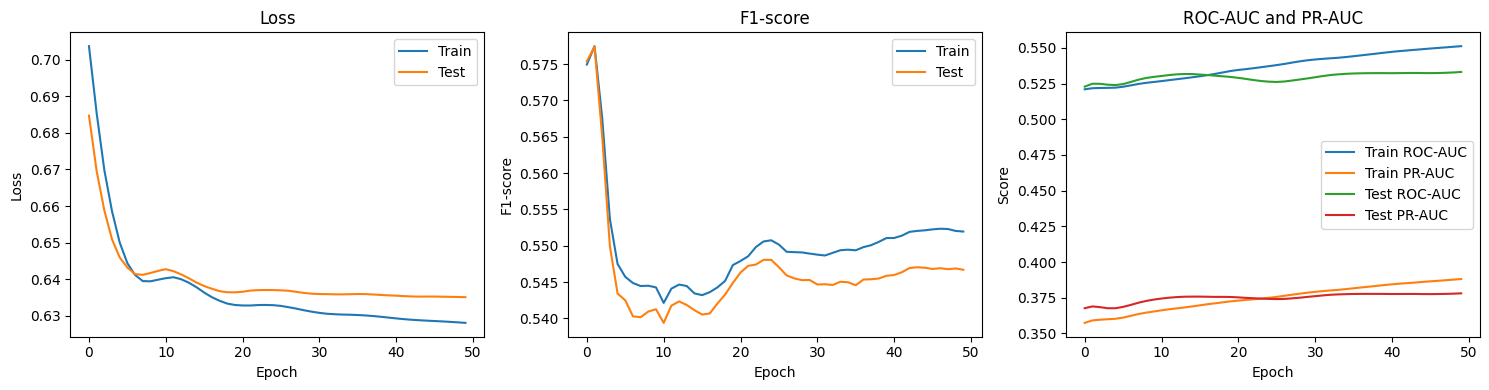

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_history, label="Train")
ax1.plot(test_loss_history, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_history, label="Train")
ax2.plot(test_f1_history, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_history, label="Train ROC-AUC")
ax3.plot(train_pr_auc_history, label="Train PR-AUC")
ax3.plot(test_roc_auc_history, label="Test ROC-AUC")
ax3.plot(test_pr_auc_history, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [36]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=feature_names)

In [37]:
df_x

,Histone_H3K36me3,Histone_H4K20me3,Histone_H3K36me2,Histone_H4K20me1,Histone_H3K27ac,Histone_H3K9me3,Histone_H3K9me2,Histone_H2A.Z,Histone_H3K18ac,Histone_CENPA,...,TFs_XRCC6,TFs_YAP1,TFs_YWHAZ,TFs_YY1,TFs_ZBTB7A,TFs_ZFX,TFs_ZFY,TFs_ZMYND11,TFs_ZMYND8,TFs_ZNF711
0,1.146623,-0.105367,-0.081604,-0.062929,0.772360,0.230818,-0.068256,1.618343,0.517362,-0.046292,...,-0.170738,0.917352,-0.287528,-0.250862,1.956601,0.018884,-0.21164,-0.060737,0.099309,-0.187513
1,-0.343734,-0.105367,-0.081604,-0.062929,-0.564400,-0.088775,-0.068256,-0.614447,-0.446403,-0.046292,...,-0.170738,-0.147503,-0.287528,-0.250862,-0.200668,-0.309851,-0.21164,-0.060737,-0.264926,-0.187513
2,-0.343734,-0.105367,-0.081604,-0.062929,0.199497,-0.377357,-0.068256,-0.488155,-0.446403,-0.046292,...,0.247818,0.841161,0.141608,-0.250862,-0.200668,-0.309851,-0.21164,-0.060737,-0.264926,-0.187513
3,-0.343734,-0.105367,-0.081604,-0.062929,-0.677140,0.047374,-0.068256,-0.043055,-0.446403,-0.046292,...,-0.170738,-0.147503,-0.287528,-0.250862,-0.200668,-0.309851,-0.21164,-0.060737,-0.264926,-0.187513
4,-0.296012,-0.105367,-0.081604,-0.062929,-0.713796,0.691897,-0.068256,-0.614447,-0.446403,-0.046292,...,-0.170738,-0.147503,-0.287528,-0.250862,-0.200668,-0.153082,-0.21164,-0.060737,-0.264926,-0.187513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80794,-0.343734,-0.105367,-0.081604,-0.062929,-0.874921,-0.377357,-0.068256,-0.614447,-0.446403,-0.046292,...,-0.170738,-0.147503,-0.287528,-0.250862,-0.200668,-0.309851,-0.21164,-0.060737,-0.264926,-0.187513
80795,2.020166,-0.105367,-0.081604,-0.062929,-0.520072,-0.377357,-0.068256,-0.614447,-0.067283,-0.046292,...,-0.170738,-0.147503,-0.287528,-0.250862,-0.200668,-0.309851,-0.21164,-0.060737,-0.264926,-0.088471
80796,0.624587,-0.105367,-0.081604,-0.062929,0.275282,-0.377357,-0.068256,0.989207,-0.309855,-0.046292,...,0.139754,-0.147503,-0.287528,5.192809,0.423064,-0.309851,-0.21164,-0.060737,-0.264926,-0.187513
80797,-0.343734,-0.105367,-0.081604,-0.062929,-0.812041,-0.247639,-0.068256,-0.614447,-0.446403,-0.046292,...,-0.170738,-0.147503,-0.287528,-0.250862,-0.200668,-0.309851,-0.21164,-0.060737,-0.264926,-0.187513


In [38]:
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [39]:
df_y

,target
0,0
1,1
2,1
3,0
4,1
...,...
80794,0
80795,1
80796,1
80797,1


In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df_x, df_y)
importances = rf.feature_importances_
for feature, importance in zip(df_x.columns, importances):
    print(f'{feature}: {importance}')

/tmp/ipykernel_23408/162895947.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_x, df_y)


Histone_H3K36me3: 0.010772870959357644
Histone_H4K20me3: 0.003567808479884106
Histone_H3K36me2: 0.0010049283373254631
Histone_H4K20me1: 0.00028873729383635717
Histone_H3K27ac: 0.027802756708010145
Histone_H3K9me3: 0.01675464202343414
Histone_H3K9me2: 0.0007828153983482761
Histone_H2A.Z: 0.016155725478069937
Histone_H3K18ac: 0.006939805660894348
Histone_CENPA: 0.000260436548123591
Histone_H3: 0.0012864672962729314
Histone_H4K5K8K12ac: 0.002697909546741902
Histone_H1: 0.00015869975243053185
Histone_H3K79me2: 0.003938163067547815
Histone_H4K12me1: 5.061925424477412e-05
Histone_H3K9K14ac: 0.0034651317488909035
Histone_H3T6ph: 0.0001242843231457728
Histone_H4ac: 0.0026767402066767932
Histone_H3T11ph: 6.529235560866962e-05
Histone_H3K9ac: 0.00544562320200246
Histone_H3K4me2: 0.02126932985678365
Histone_H3K4me3: 0.017192856448238408
Histone_H3K27me3: 0.027948945311203944
Histone_H2A.ZK4K7K11ac: 0.009161963709017838
Histone_H3K4me1: 0.025796020565573903
Histone_H2BK15ac: 0.0034160229911402123


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


/tmp/ipykernel_23408/4292731798.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


F1-score: 0.2945
ROC-AUC: 0.5262
PR-AUC: 0.4432


              feature  importance
40             TFs_AR    0.032628
87          TFs_FOXA1    0.030603
4     Histone_H3K27ac    0.027610
22   Histone_H3K27me3    0.027278
24    Histone_H3K4me1    0.025691
..                ...         ...
91           TFs_FXR1    0.000033
115         TFs_MED12    0.000028
89          TFs_FOXM1    0.000026
177        TFs_TRIM33    0.000022
51          TFs_CCNT1    0.000014

[193 rows x 2 columns]


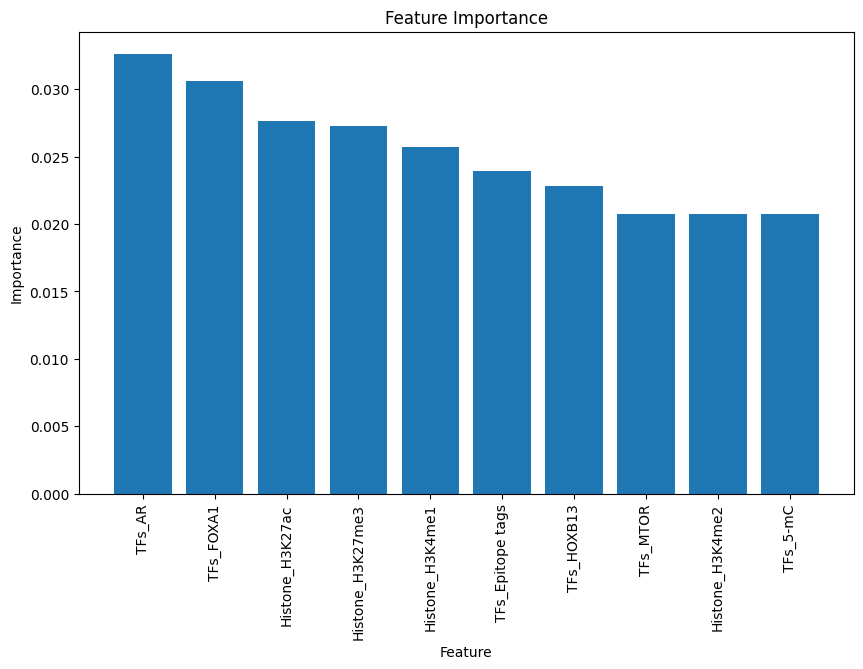

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [43]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6816649	total: 61.7ms	remaining: 1m 1s
1:	learn: 0.6723439	total: 74.2ms	remaining: 37s
2:	learn: 0.6647156	total: 86.1ms	remaining: 28.6s
3:	learn: 0.6585709	total: 98.2ms	remaining: 24.5s
4:	learn: 0.6537080	total: 110ms	remaining: 21.9s
5:	learn: 0.6497700	total: 122ms	remaining: 20.3s
6:	learn: 0.6464775	total: 135ms	remaining: 19.1s
7:	learn: 0.6438407	total: 147ms	remaining: 18.2s
8:	learn: 0.6417117	total: 160ms	remaining: 17.7s
9:	learn: 0.6399772	total: 172ms	remaining: 17s
10:	learn: 0.6385782	total: 184ms	remaining: 16.6s
11:	learn: 0.6372896	total: 197ms	remaining: 16.2s
12:	learn: 0.6361596	total: 210ms	remaining: 15.9s
13:	learn: 0.6353211	total: 222ms	remaining: 15.6s
14:	learn: 0.6346148	total: 234ms	remaining: 15.3s
15:	learn: 0.6339933	total: 246ms	remaining: 15.1s
16:	learn: 0.6334767	total: 259ms	remaining: 15s
17:	learn: 0.6330683	total: 271ms	remaining: 14.8s
18:	learn: 0.6326905	total: 283ms	remaining: 14.6s
19:	learn: 0.6323015	total: 296ms	remaining

161:	learn: 0.6078880	total: 2.11s	remaining: 11s
162:	learn: 0.6077069	total: 2.12s	remaining: 11s
163:	learn: 0.6075222	total: 2.13s	remaining: 10.9s
164:	learn: 0.6073065	total: 2.15s	remaining: 10.9s
165:	learn: 0.6071686	total: 2.16s	remaining: 10.9s
166:	learn: 0.6070123	total: 2.17s	remaining: 10.9s
167:	learn: 0.6068562	total: 2.19s	remaining: 10.9s
168:	learn: 0.6066598	total: 2.2s	remaining: 10.9s
169:	learn: 0.6064535	total: 2.21s	remaining: 10.9s
170:	learn: 0.6062539	total: 2.23s	remaining: 10.9s
171:	learn: 0.6060986	total: 2.24s	remaining: 10.8s
172:	learn: 0.6059185	total: 2.25s	remaining: 10.8s
173:	learn: 0.6057893	total: 2.26s	remaining: 10.8s
174:	learn: 0.6055683	total: 2.28s	remaining: 10.8s
175:	learn: 0.6054584	total: 2.29s	remaining: 10.8s
176:	learn: 0.6052565	total: 2.3s	remaining: 10.8s
177:	learn: 0.6050877	total: 2.32s	remaining: 10.8s
178:	learn: 0.6049227	total: 2.33s	remaining: 10.7s
179:	learn: 0.6047593	total: 2.34s	remaining: 10.7s
180:	learn: 0.6045

321:	learn: 0.5832206	total: 5.04s	remaining: 10.7s
322:	learn: 0.5831207	total: 5.06s	remaining: 10.7s
323:	learn: 0.5829451	total: 5.07s	remaining: 10.6s
324:	learn: 0.5827773	total: 5.08s	remaining: 10.6s
325:	learn: 0.5826177	total: 5.1s	remaining: 10.6s
326:	learn: 0.5825256	total: 5.11s	remaining: 10.6s
327:	learn: 0.5824004	total: 5.12s	remaining: 10.6s
328:	learn: 0.5822360	total: 5.13s	remaining: 10.5s
329:	learn: 0.5821239	total: 5.15s	remaining: 10.5s
330:	learn: 0.5819611	total: 5.16s	remaining: 10.5s
331:	learn: 0.5818075	total: 5.17s	remaining: 10.5s
332:	learn: 0.5816973	total: 5.19s	remaining: 10.5s
333:	learn: 0.5815812	total: 5.2s	remaining: 10.4s
334:	learn: 0.5814789	total: 5.21s	remaining: 10.4s
335:	learn: 0.5812969	total: 5.22s	remaining: 10.4s
336:	learn: 0.5811542	total: 5.24s	remaining: 10.4s
337:	learn: 0.5810239	total: 5.25s	remaining: 10.3s
338:	learn: 0.5809336	total: 5.26s	remaining: 10.3s
339:	learn: 0.5807781	total: 5.28s	remaining: 10.3s
340:	learn: 0.

481:	learn: 0.5628712	total: 8.85s	remaining: 9.57s
482:	learn: 0.5627765	total: 8.87s	remaining: 9.55s
483:	learn: 0.5626903	total: 8.88s	remaining: 9.53s
484:	learn: 0.5625852	total: 8.89s	remaining: 9.5s
485:	learn: 0.5624833	total: 8.9s	remaining: 9.48s
486:	learn: 0.5624080	total: 8.92s	remaining: 9.45s
487:	learn: 0.5622885	total: 8.93s	remaining: 9.43s
488:	learn: 0.5621716	total: 8.94s	remaining: 9.4s
489:	learn: 0.5620677	total: 8.96s	remaining: 9.38s
490:	learn: 0.5619311	total: 8.97s	remaining: 9.36s
491:	learn: 0.5618697	total: 8.98s	remaining: 9.33s
492:	learn: 0.5617414	total: 9s	remaining: 9.31s
493:	learn: 0.5615900	total: 9.01s	remaining: 9.29s
494:	learn: 0.5614699	total: 9.02s	remaining: 9.26s
495:	learn: 0.5614128	total: 9.04s	remaining: 9.24s
496:	learn: 0.5613018	total: 9.05s	remaining: 9.21s
497:	learn: 0.5611763	total: 9.06s	remaining: 9.19s
498:	learn: 0.5610891	total: 9.07s	remaining: 9.17s
499:	learn: 0.5609534	total: 9.09s	remaining: 9.14s
500:	learn: 0.5608

641:	learn: 0.5458890	total: 11.8s	remaining: 6.61s
642:	learn: 0.5457320	total: 11.8s	remaining: 6.59s
643:	learn: 0.5456360	total: 11.8s	remaining: 6.57s
644:	learn: 0.5455539	total: 11.8s	remaining: 6.55s
645:	learn: 0.5454558	total: 11.8s	remaining: 6.53s
646:	learn: 0.5453431	total: 11.9s	remaining: 6.51s
647:	learn: 0.5451875	total: 11.9s	remaining: 6.49s
648:	learn: 0.5450374	total: 11.9s	remaining: 6.46s
649:	learn: 0.5449452	total: 11.9s	remaining: 6.44s
650:	learn: 0.5448411	total: 11.9s	remaining: 6.42s
651:	learn: 0.5447295	total: 11.9s	remaining: 6.4s
652:	learn: 0.5446384	total: 11.9s	remaining: 6.38s
653:	learn: 0.5445013	total: 11.9s	remaining: 6.36s
654:	learn: 0.5444168	total: 12s	remaining: 6.33s
655:	learn: 0.5443378	total: 12s	remaining: 6.31s
656:	learn: 0.5442150	total: 12s	remaining: 6.29s
657:	learn: 0.5440463	total: 12s	remaining: 6.27s
658:	learn: 0.5439311	total: 12s	remaining: 6.25s
659:	learn: 0.5438530	total: 12s	remaining: 6.23s
660:	learn: 0.5437760	tot

801:	learn: 0.5307169	total: 13.9s	remaining: 3.44s
802:	learn: 0.5306705	total: 13.9s	remaining: 3.42s
803:	learn: 0.5305335	total: 13.9s	remaining: 3.4s
804:	learn: 0.5303741	total: 13.9s	remaining: 3.38s
805:	learn: 0.5302876	total: 13.9s	remaining: 3.36s
806:	learn: 0.5301907	total: 13.9s	remaining: 3.35s
807:	learn: 0.5301506	total: 13.9s	remaining: 3.33s
808:	learn: 0.5300849	total: 13.9s	remaining: 3.31s
809:	learn: 0.5299421	total: 14s	remaining: 3.29s
810:	learn: 0.5298579	total: 14s	remaining: 3.27s
811:	learn: 0.5297883	total: 14s	remaining: 3.25s
812:	learn: 0.5297340	total: 14s	remaining: 3.24s
813:	learn: 0.5296364	total: 14s	remaining: 3.22s
814:	learn: 0.5295248	total: 14s	remaining: 3.2s
815:	learn: 0.5294228	total: 14s	remaining: 3.18s
816:	learn: 0.5293145	total: 14.1s	remaining: 3.16s
817:	learn: 0.5292042	total: 14.1s	remaining: 3.14s
818:	learn: 0.5291459	total: 14.1s	remaining: 3.13s
819:	learn: 0.5290939	total: 14.1s	remaining: 3.11s
820:	learn: 0.5290343	total:

961:	learn: 0.5168046	total: 15.9s	remaining: 632ms
962:	learn: 0.5167427	total: 15.9s	remaining: 615ms
963:	learn: 0.5166788	total: 16s	remaining: 598ms
964:	learn: 0.5166304	total: 16s	remaining: 582ms
965:	learn: 0.5164986	total: 16s	remaining: 565ms
966:	learn: 0.5164249	total: 16s	remaining: 548ms
967:	learn: 0.5163565	total: 16s	remaining: 531ms
968:	learn: 0.5162436	total: 16s	remaining: 515ms
969:	learn: 0.5161649	total: 16s	remaining: 498ms
970:	learn: 0.5160499	total: 16s	remaining: 481ms
971:	learn: 0.5159495	total: 16.1s	remaining: 465ms
972:	learn: 0.5158839	total: 16.1s	remaining: 448ms
973:	learn: 0.5158157	total: 16.1s	remaining: 431ms
974:	learn: 0.5157573	total: 16.1s	remaining: 415ms
975:	learn: 0.5156741	total: 16.1s	remaining: 398ms
976:	learn: 0.5155917	total: 16.1s	remaining: 381ms
977:	learn: 0.5154995	total: 16.1s	remaining: 365ms
978:	learn: 0.5154101	total: 16.2s	remaining: 348ms
979:	learn: 0.5153568	total: 16.2s	remaining: 331ms
980:	learn: 0.5152740	total:

In [44]:
feature_importances = model.feature_importances_
for feature_name, feature_importance in zip(df_x.columns, feature_importances):
    print(f"{feature_name}: {feature_importance}")

Histone_H3K36me3: 0.7162158360082083
Histone_H4K20me3: 0.36841816266816774
Histone_H3K36me2: 0.09349829852724119
Histone_H4K20me1: 0.03040120865374534
Histone_H3K27ac: 2.0997165393779693
Histone_H3K9me3: 1.3232070184005225
Histone_H3K9me2: 0.1056528826934869
Histone_H2A.Z: 0.9762509064526658
Histone_H3K18ac: 0.8254433588439287
Histone_CENPA: 0.09422598271043528
Histone_H3: 0.2543614119272844
Histone_H4K5K8K12ac: 0.1985851800417215
Histone_H1: 0.008524018267913875
Histone_H3K79me2: 0.3737165263494307
Histone_H4K12me1: 0.011639707018554933
Histone_H3K9K14ac: 0.2365636299158851
Histone_H3T6ph: 0.015019126653685405
Histone_H4ac: 0.2627814460609467
Histone_H3T11ph: 0.01243213609899848
Histone_H3K9ac: 0.4913562707783756
Histone_H3K4me2: 1.638024295603374
Histone_H3K4me3: 1.619353436596097
Histone_H3K27me3: 2.142350389938421
Histone_H2A.ZK4K7K11ac: 1.0133294048271524
Histone_H3K4me1: 2.3549309373879317
Histone_H2BK15ac: 0.2570562484809392
Histone_H3K14ac: 0.3887845277742376
Histone_H4K5ac: 0.

              feature  importance
40             TFs_AR    2.484648
24    Histone_H3K4me1    2.354931
22   Histone_H3K27me3    2.142350
4     Histone_H3K27ac    2.099717
87          TFs_FOXA1    2.079149
..                ...         ...
56         TFs_COBLL1    0.000003
163         TFs_STAT2    0.000000
160       TFs_SMARCB1    0.000000
190       TFs_ZMYND11    0.000000
73           TFs_ELK4    0.000000

[193 rows x 2 columns]


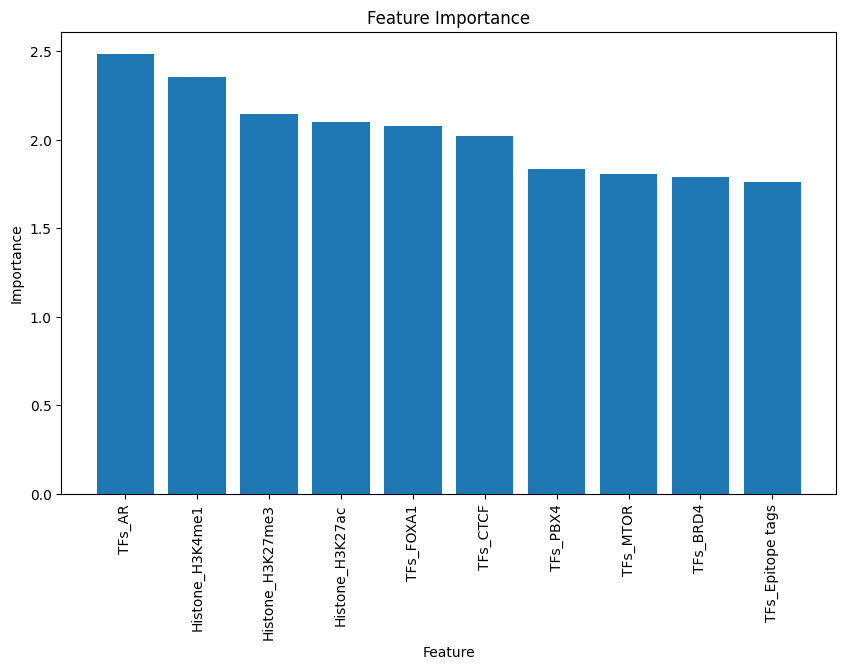

In [45]:
importances = feature_importances
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
